<a href="https://colab.research.google.com/github/safeai-snu/TimeSeriesAI/blob/main/ch1/ch1_1,2_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 실습은 Marco Peixeiro의 Time Series Forecasting in Python 책과 코드를 참조해 만들었다.

본 코드는 https://github.com/jpub-dongdong9/TimeSeriesForecastingInPython/tree/master 에서도 찾을 수 있다.

# Data Preprocessing

### 필요한 패키지 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

### 데이터 로드

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/beijing_air_quality.csv')
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin,2015-01-02 22:00:00
1,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin,2015-01-02 23:00:00
2,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin,2015-01-03 00:00:00
3,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin,2015-01-03 01:00:00
4,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin,2015-01-03 02:00:00


In [4]:
df.shape

(18914, 15)

### 시각화

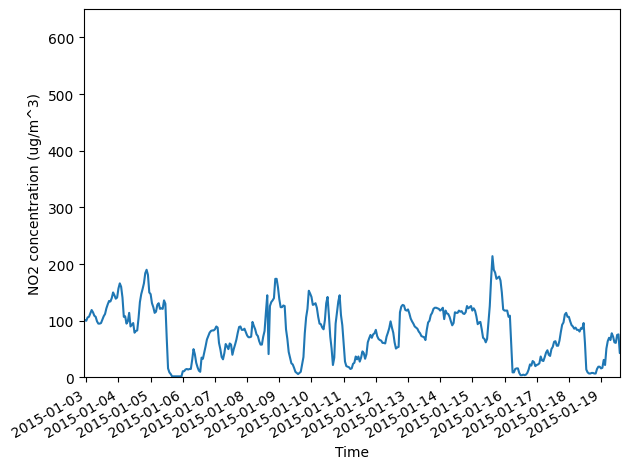

In [5]:
fig, ax = plt.subplots()

ax.plot(df['NO2'])
ax.set_xlabel('Time')
ax.set_ylabel('NO2 concentration (ug/m^3)')

plt.xticks(np.arange(2, 400, 24), ['2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18', '2015-01-19'])
plt.ylim(0, 650)
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

### 데이터 통계

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No,18914.0,25607.500000,5460.145831,16151.0,20879.250,25607.5,30335.75,35064.0
PM2.5,18914.0,79.407220,83.816615,3.0,19.000,54.0,107.00,898.0
PM10,18914.0,103.687485,95.725767,3.0,33.225,78.0,143.00,984.0
SO2,18914.0,13.201725,17.090182,2.0,2.000,7.0,16.00,341.0
NO2,18914.0,55.560272,37.834273,2.0,26.000,47.0,77.00,290.0
CO,18914.0,1324.737573,1351.213878,100.0,500.000,900.0,1600.00,10000.0
O3,18914.0,61.602319,58.980450,2.0,13.000,49.0,87.00,423.0
TEMP,18914.0,12.741331,11.751367,-16.8,2.000,13.0,23.10,38.8
PRES,18914.0,1013.480721,10.470266,987.5,1004.900,1013.2,1022.10,1042.0
DEWP,18914.0,1.399363,13.830859,-35.3,-10.100,1.3,14.00,27.3


### 불필요한 열 제거

In [7]:
cols_to_drop = ['RAIN', 'wd', 'No', 'station']

df = df.drop(cols_to_drop, axis=1)

df.shape

(18914, 11)

### 시간 변환

In [8]:
timestamp_s = pd.to_datetime(df.datetime).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

df = df.drop(['datetime'], axis=1)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,day_sin,day_cos
0,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7,-0.258819,-0.965926
1,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7,-0.500000,-0.866025
2,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,-0.707107,-0.707107
3,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4,-0.866025,-0.500000
4,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1,-0.965926,-0.258819


### 데이터셋 분리

In [9]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((13239, 12), (3783, 12), (1892, 12))

### 데이터 스케일링

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

### 데이터 윈도우

In [11]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [12]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Models

In [13]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Single-step model

### Baseline model

In [14]:
#윈도우 설정
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [15]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [16]:
#모델 피팅
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [17]:
#성능 평가
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)


119/119 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_absolute_error: 0.0287


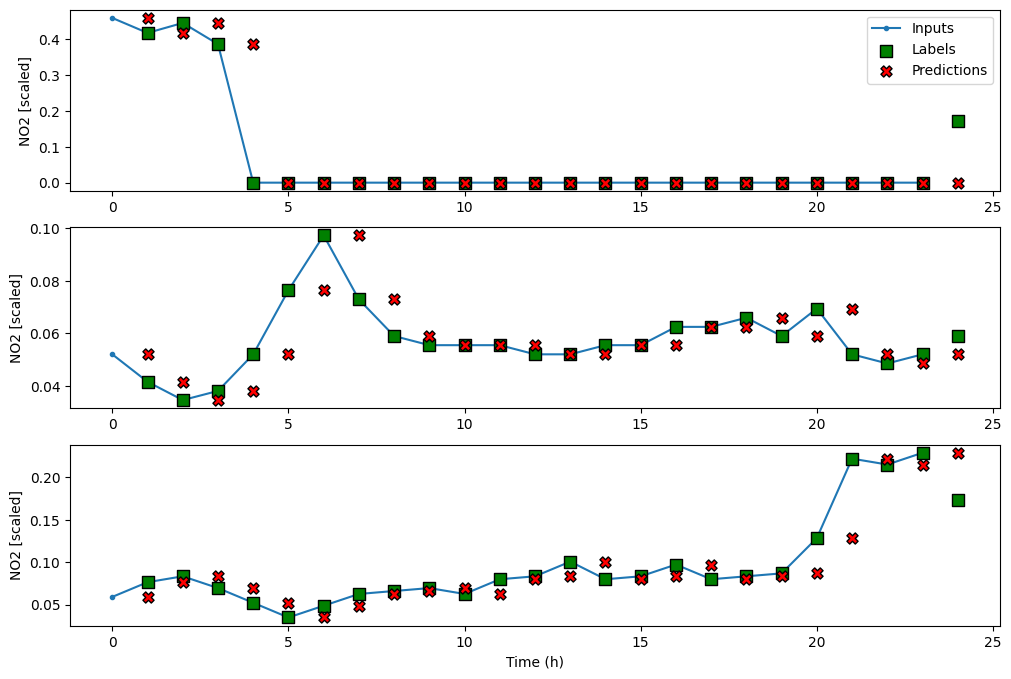

In [18]:
#시각화
wide_window.plot(baseline_last)

### Linear model

In [19]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 2ms/step - loss: 0.1408 - mean_absolute_error: 0.3010 - val_loss: 0.0672 - val_mean_absolute_error: 0.2088
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0435 - mean_absolute_error: 0.1669 - val_loss: 0.0199 - val_mean_absolute_error: 0.1131
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0925 - val_loss: 0.0063 - val_mean_absolute_error: 0.0629
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0586 - val_loss: 0.0035 - val_mean_absolute_error: 0.0448
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0029 - val_mean_absolute_error: 0.0398
Epoch 6/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0409 - val_loss: 0.0026 - val_mean_absolute_error: 0.0369
Epoch 7/50
414/4

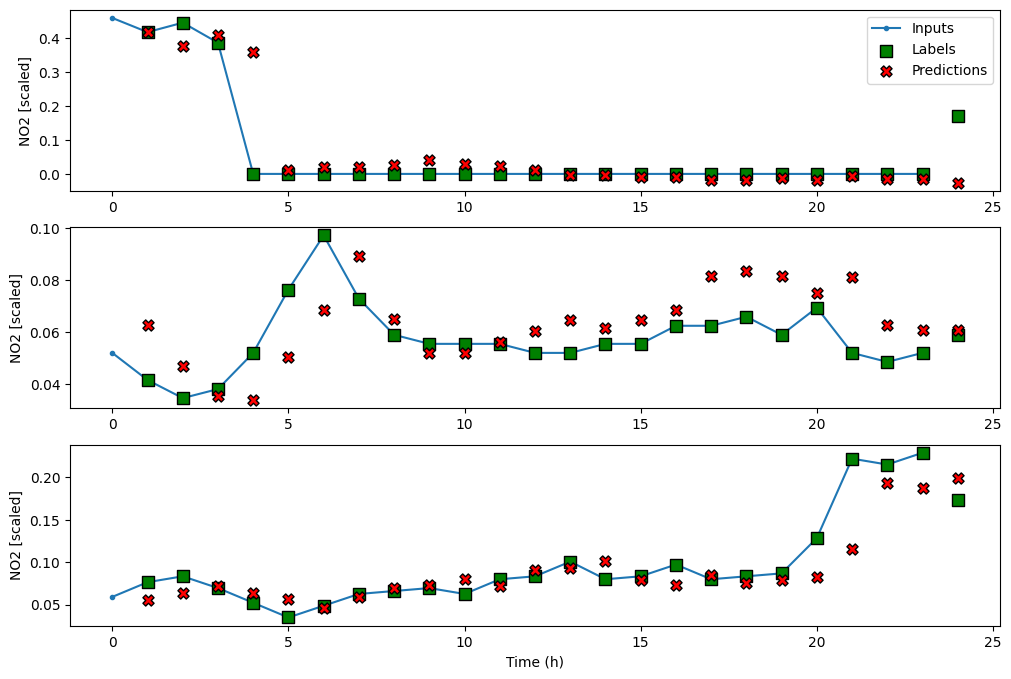

In [20]:
#시각화
wide_window.plot(linear)

### DNN

In [21]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0338 - val_loss: 0.0020 - val_mean_absolute_error: 0.0287
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0022 - val_mean_absolute_error: 0.0314
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0019 - val_mean_absolute_error: 0.0272
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0268 - val_loss: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0267 - val_loss: 0.0020 - val_mean_absolute_error: 0.0285
Epoch 6/50
119/119 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_absolute_error: 0.0316


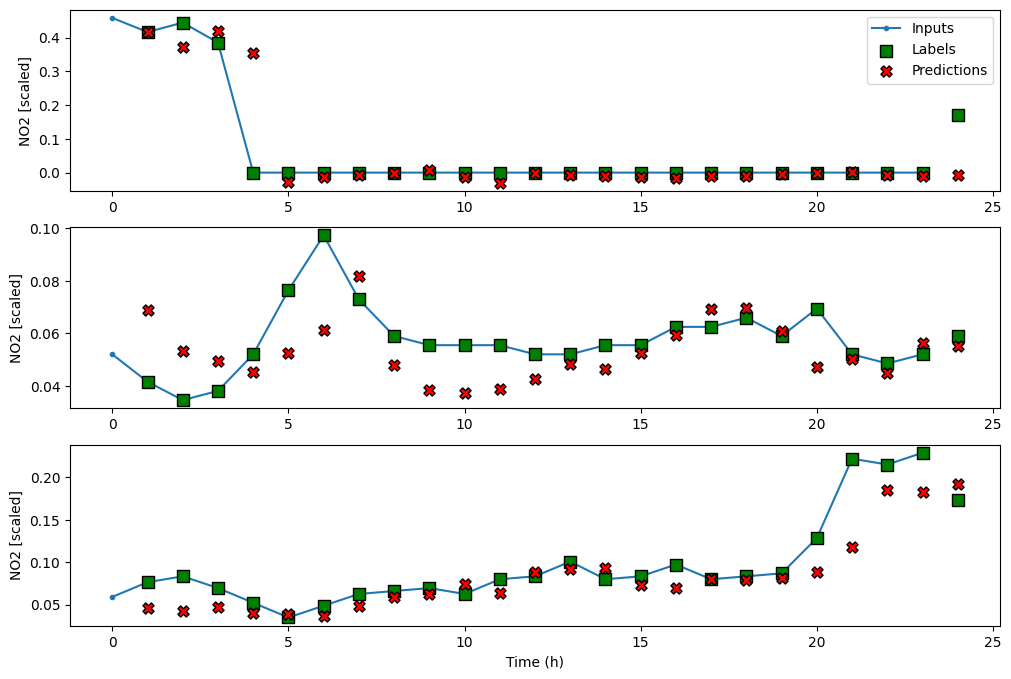

In [22]:
#시각화
wide_window.plot(dense)

### 결과 비교

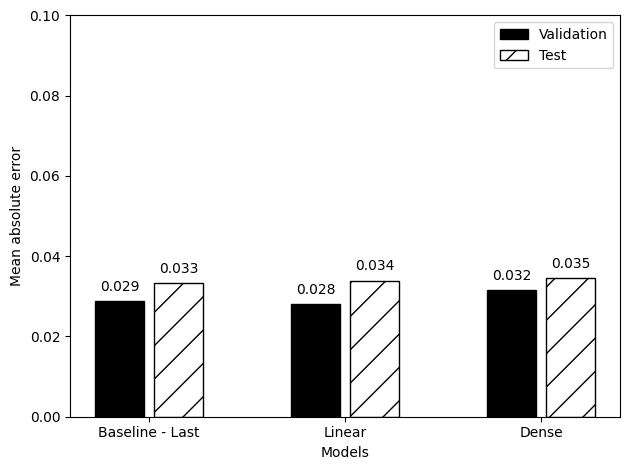

In [23]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model

### Baseline model

In [24]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])


class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])
    
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 1ms/step - loss: 0.1443 - mean_absolute_error: 0.2821


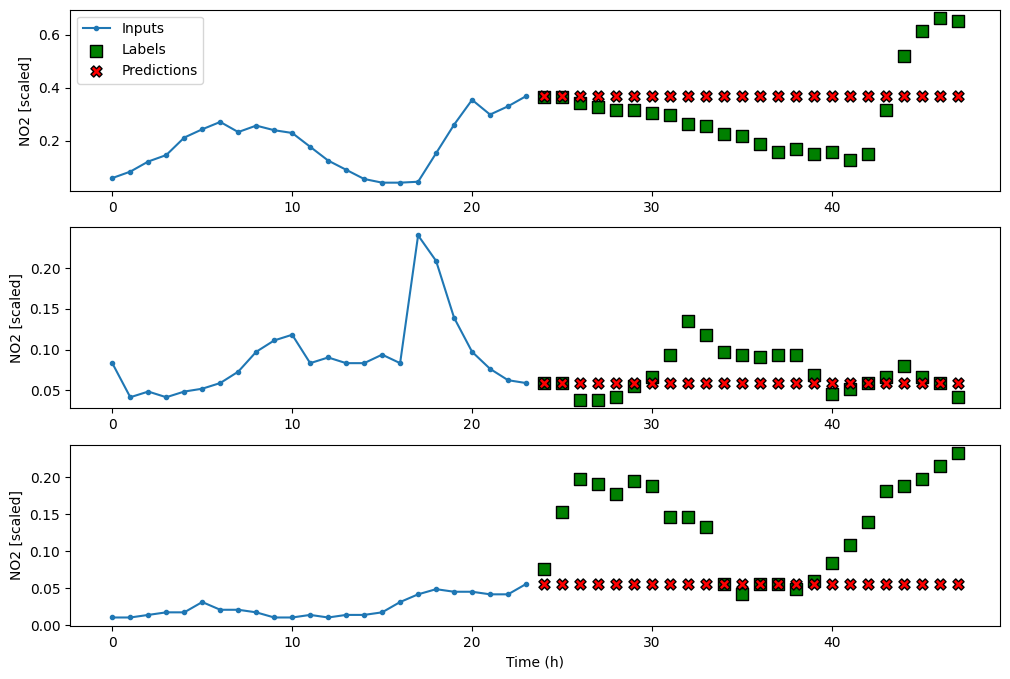

In [25]:
#시각화
multi_window.plot(ms_baseline_last)

### Linear model

In [26]:
label_index = column_indices['NO2']
num_features = train_df.shape[1]

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0942 - val_loss: 0.0097 - val_mean_absolute_error: 0.0745
Epoch 2/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0846 - val_loss: 0.0091 - val_mean_absolute_error: 0.0723
Epoch 3/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0120 - mean_absolute_error: 0.0836 - val_loss: 0.0089 - val_mean_absolute_error: 0.0711
Epoch 4/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0118 - mean_absolute_error: 0.0828 - val_loss: 0.0088 - val_mean_absolute_error: 0.0707
Epoch 5/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0823 - val_loss: 0.0087 - val_mean_absolute_error: 0.0707
Epoch 6/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0819 - val_loss: 0.0088 - val_mean_absolute_error: 0.0700
Epoch 7/50
413/4

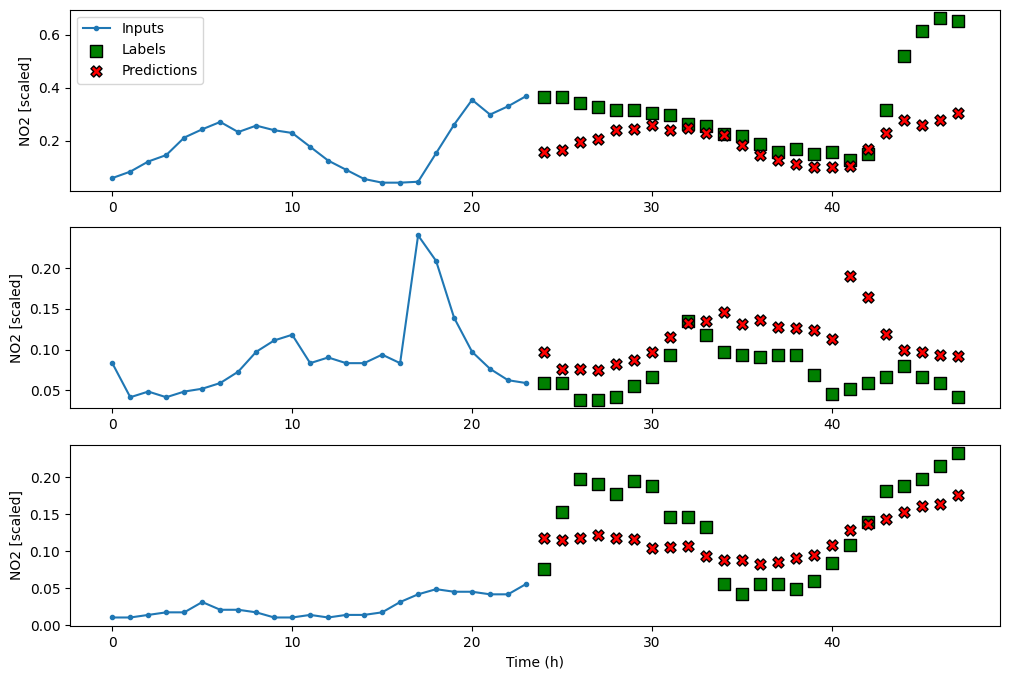

In [27]:
multi_window.plot(ms_linear)

### DNN

In [28]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0860 - val_loss: 0.0086 - val_mean_absolute_error: 0.0689
Epoch 2/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0793 - val_loss: 0.0093 - val_mean_absolute_error: 0.0708
Epoch 3/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0785 - val_loss: 0.0089 - val_mean_absolute_error: 0.0696
Epoch 4/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0702


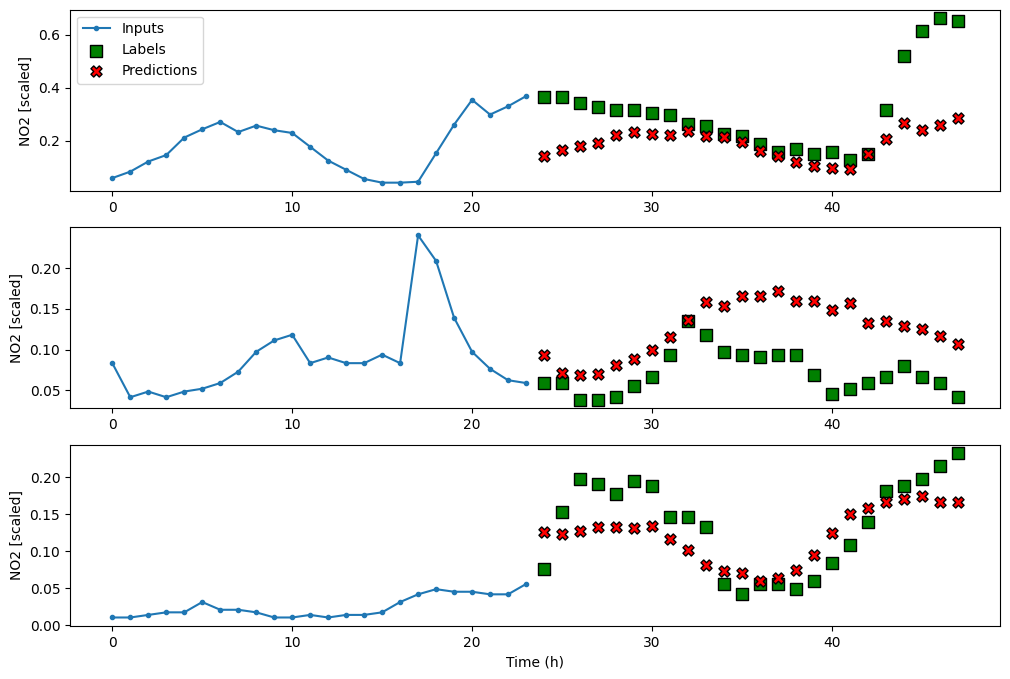

In [29]:
multi_window.plot(ms_dense)

### 결과 비교

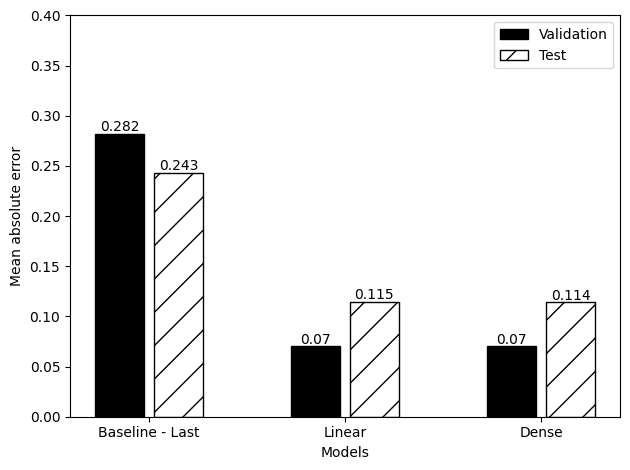

In [30]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### Multi-output model

In [31]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])


mo_baseline_last = Baseline(label_index=[column_indices['NO2'], column_indices['TEMP']])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0215


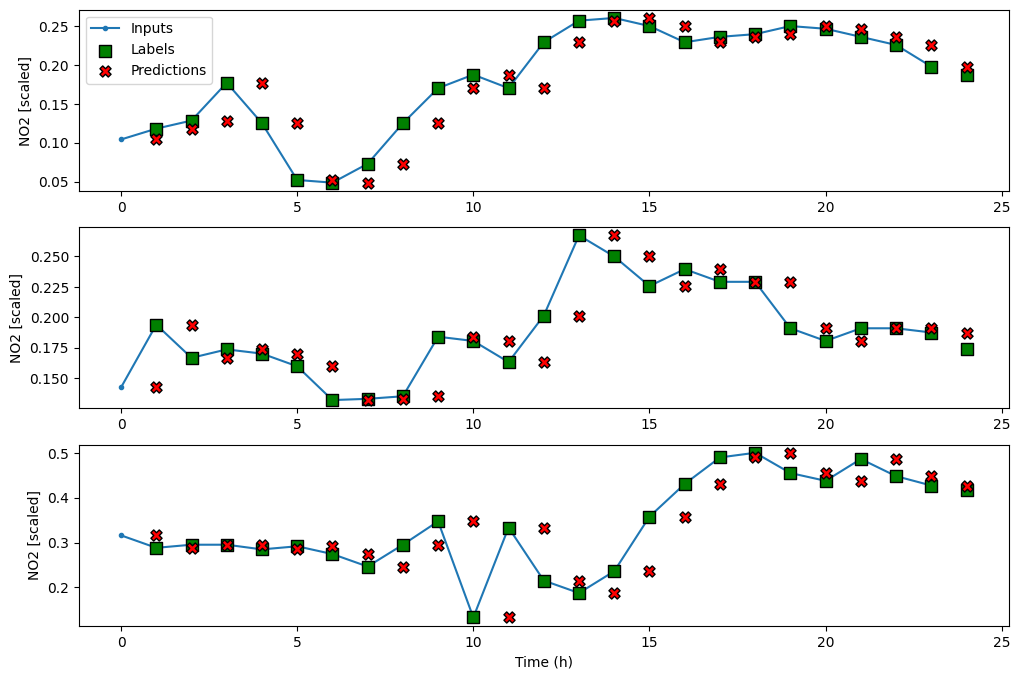

In [32]:
#시각화
mo_wide_window.plot(mo_baseline_last)

### Linear model

In [33]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0920 - mean_absolute_error: 0.2323 - val_loss: 0.0182 - val_mean_absolute_error: 0.1110
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.1004 - val_loss: 0.0081 - val_mean_absolute_error: 0.0717
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0719 - val_loss: 0.0048 - val_mean_absolute_error: 0.0548
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0035 - val_mean_absolute_error: 0.0463
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0028 - val_mean_absolute_error: 0.0408
Epoch 6/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0428 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366
Epoch 7/50
414/4

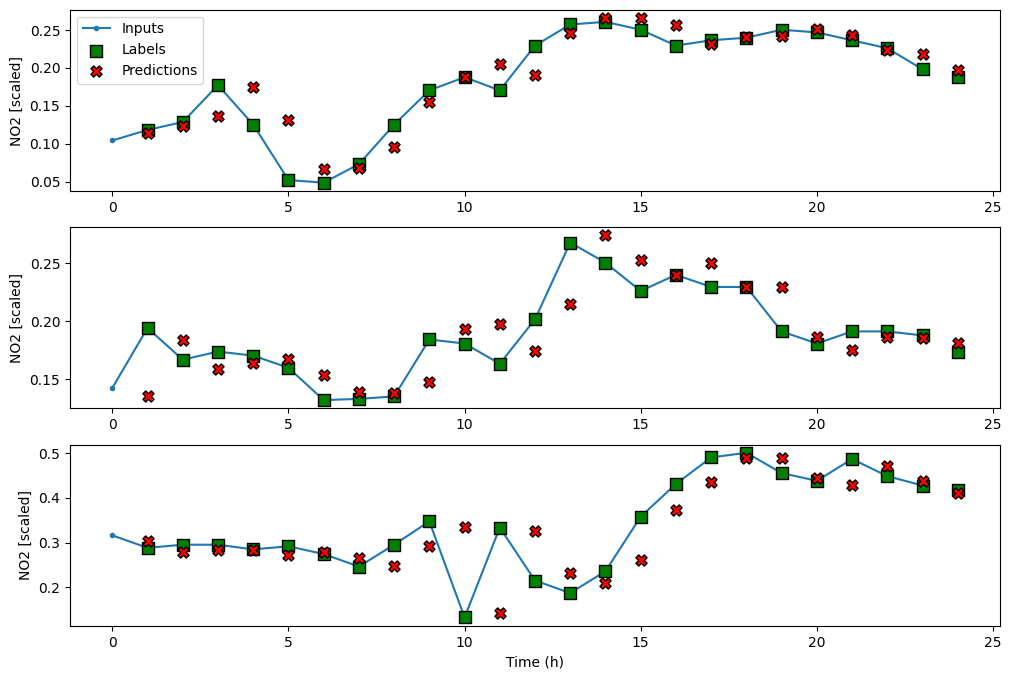

In [34]:
mo_wide_window.plot(mo_linear)

### DNN

In [35]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 2ms/step - loss: 0.0053 - mean_absolute_error: 0.0405 - val_loss: 0.0012 - val_mean_absolute_error: 0.0229
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0214 - val_loss: 0.0011 - val_mean_absolute_error: 0.0208
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 9.9791e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0011 - val_mean_absolute_error: 0.0202
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 9.9194e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0016 - val_mean_absolute_error: 0.0258
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 9.7413e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0012 - val_mean_absolute_error: 0.0211
Epoch 6/50
119/119 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0206


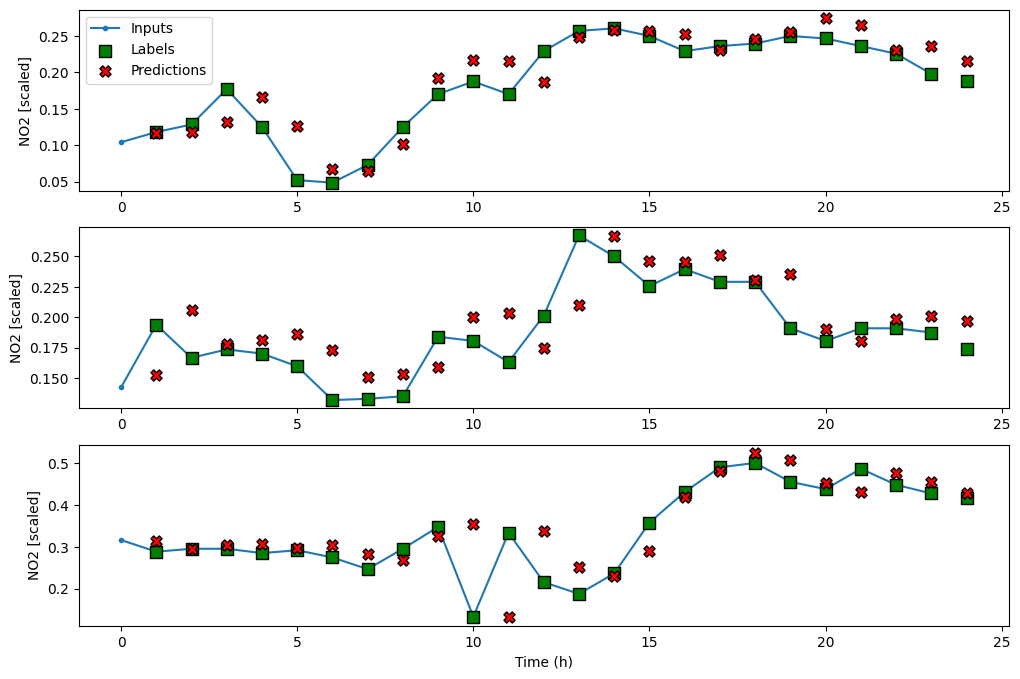

In [36]:
mo_wide_window.plot(mo_dense)

### 결과 비교

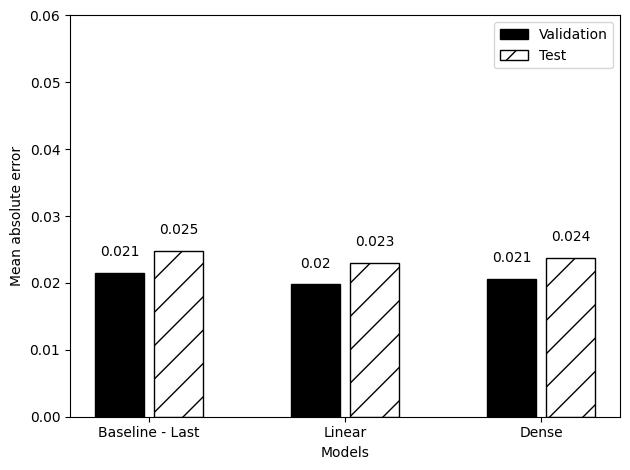

In [37]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()